In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import joblib

## Prepare dataset

In [3]:
# 1. Load data
file_path = 'E:/Folu Net Sink 2030/Lidar Gedi/gedi_sentinel1_extracted_values/gedi_sentinel2_extracted_values.csv'
data = pd.read_csv(file_path, sep=';')
data

,new_attrib,fid,date,B11,B12,agbd,MSK_CLDPRB,layer,B2,B3,path,B4,B5,lat_lowest,B6,B7,B8,lon_lowest,VV,VH,angle
0,03/05/2019,1,1.556840e+12,NaN,NaN,10.299632,NaN,GEDI04_A_20190503_2019123032136_O02194_04_T045...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.745737,NaN,NaN,NaN,116.890712,-8.723801,-15.847018,36.684093
1,03/05/2019,2,1.556840e+12,NaN,NaN,11.244361,NaN,GEDI04_A_20190503_2019123032136_O02194_04_T045...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.746180,NaN,NaN,NaN,116.890978,-6.801365,-13.817563,36.682808
2,03/05/2019,3,1.556840e+12,NaN,NaN,21.002218,NaN,GEDI04_A_20190503_2019123032136_O02194_04_T045...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.746622,NaN,NaN,NaN,116.891244,-7.693880,-16.705975,36.681526
3,03/05/2019,4,1.556840e+12,NaN,NaN,10.138819,NaN,GEDI04_A_20190503_2019123032136_O02194_04_T045...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.747063,NaN,NaN,NaN,116.891509,-9.159604,-18.787155,36.680248
4,03/05/2019,5,1.556840e+12,NaN,NaN,10.102147,NaN,GEDI04_A_20190503_2019123032136_O02194_04_T045...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.747504,NaN,NaN,NaN,116.891775,-8.107211,-14.260855,36.678974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43243,22/01/2023,43244,1.674350e+12,NaN,NaN,82.414917,NaN,GEDI04_A_20230122_2023022165349_O23291_04_T102...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.827226,NaN,NaN,NaN,116.891122,-10.289781,-17.105918,36.219677
43244,22/01/2023,43245,1.674350e+12,NaN,NaN,185.109634,NaN,GEDI04_A_20230122_2023022165349_O23291_04_T102...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.827650,NaN,NaN,NaN,116.891422,-3.547798,-11.572578,36.217567
43245,22/01/2023,43246,1.674350e+12,NaN,NaN,179.507996,NaN,GEDI04_A_20230122_2023022165349_O23291_04_T102...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.828073,NaN,NaN,NaN,116.891719,-4.294481,-11.780784,36.215881
43246,22/01/2023,43247,1.674350e+12,NaN,NaN,46.767803,NaN,GEDI04_A_20230122_2023022165349_O23291_04_T102...,NaN,NaN,H:/(2024) FOLU/01. AGB GEDI/Lidar GEDI_AGB_Ful...,NaN,NaN,-0.828496,NaN,NaN,NaN,116.892017,-4.296510,-10.242908,36.214291


In [4]:
# 2. Select relevant columns and drop rows with missing values in selected columns
features = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'VV', 'VH']
target = 'agbd'
data = data.dropna(subset=features + [target])

In [6]:
# 3. Convert date to datetime format and sort by 'fid' and date
data['new_attrib'] = pd.to_datetime(data['new_attrib'], format='%d/%m/%Y')
data = data.sort_values(by=['fid', 'new_attrib'])

In [5]:
# 4. Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
# 5. Group by 'fid' to get each location's multitemporal data
grouped = data.groupby('fid')

In [8]:
# 6. Define x and y
X, y = [], []

for _, group in grouped:
    # Sort group by date and convert to numpy
    group = group.sort_values('new_attrib')
    X.append(group[features].values)  # Collect feature values
    y.append(group[target].values)    # Collect target values

# Pad sequences to ensure each location has the same length of timesteps
X = pad_sequences(X, padding='post', dtype='float32')
y = pad_sequences(y, padding='post', dtype='float32')

In [9]:
# 7. Split data into train and test (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 8. Reshape data for input into 1D CNN and CNN-LSTM (samples, timesteps, features)
# X has shape (samples, timesteps, features)
input_shape = (X_train.shape[1], X_train.shape[2])

## 1D-CNN

In [11]:
# 1. Define a 1D CNN model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse')
    return model

In [12]:
# 2. Custom callback to compute R2 on train and validation data
class R2ScoreCallback(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        X_train, y_train = self.train_data
        X_val, y_val = self.val_data

        # Predict on training and validation data
        y_train_pred = self.model.predict(X_train, verbose=0)
        y_val_pred = self.model.predict(X_val, verbose=0)

        # Compute R²
        r2_train = r2_score(y_train.flatten(), y_train_pred.flatten())
        r2_val = r2_score(y_val.flatten(), y_val_pred.flatten())

        # Log R² scores
        logs['r2_train'] = r2_train
        logs['r2_val'] = r2_val
        print(f" - r2_train: {r2_train:.4f} - r2_val: {r2_val:.4f}")

In [13]:
# 3. Directory for storing files 
save_path = os.path.join("Script\model")
model_cnn_path = os.path.join(save_path, "cnn_model.h5")
csv_cnn_path = os.path.join(save_path, "cnn_data.csv")

callbacks_cnn = [
    ModelCheckpoint(model_cnn_path,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(csv_cnn_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    R2ScoreCallback((X_train, y_train), (X_test, y_test))
]

In [15]:
# 4. Train and evaluate 1D CNN model
cnn_model = build_cnn_model(input_shape)
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, callbacks=callbacks_cnn, validation_data=(X_test, y_test))

Epoch 1/50
619/619 [==============================] - 24s 38ms/step - loss: 18714.6250 - val_loss: 16405.2988 - lr: 0.0010 - r2_train: -0.1699 - r2_val: -0.1490
Epoch 2/50
619/619 [==============================] - 24s 39ms/step - loss: 14936.0771 - val_loss: 17685.6152 - lr: 0.0010 - r2_train: -0.2741 - r2_val: -0.2387
Epoch 3/50
619/619 [==============================] - 24s 39ms/step - loss: 14599.0186 - val_loss: 13006.4258 - lr: 0.0010 - r2_train: 0.0761 - r2_val: 0.0890
Epoch 4/50
619/619 [==============================] - 24s 39ms/step - loss: 14758.2695 - val_loss: 17998.9297 - lr: 0.0010 - r2_train: -0.2828 - r2_val: -0.2607
Epoch 5/50
619/619 [==============================] - 23s 37ms/step - loss: 13415.9160 - val_loss: 12804.1387 - lr: 0.0010 - r2_train: 0.0821 - r2_val: 0.1032
Epoch 6/50
619/619 [==============================] - 20s 32ms/step - loss: 13114.2539 - val_loss: 13462.4189 - lr: 0.0010 - r2_train: 0.0525 - r2_val: 0.0571
Epoch 7/50
619/619 [====================

In [16]:
# 5. Predict and evaluate 1D CNN model
y_pred_cnn = cnn_model.predict(X_test)
r2_cnn = r2_score(y_test.flatten(), y_pred_cnn.flatten())
mae_cnn = mean_absolute_error(y_test.flatten(), y_pred_cnn.flatten())
rmse_cnn = np.sqrt(mean_squared_error(y_test.flatten(), y_pred_cnn.flatten()))

print("\n1D CNN Performance:")
print(f"R²: {r2_cnn:.4f}")
print(f"MAE: {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")

78/78 [==============================] - 0s 1ms/step

1D CNN Performance:
R²: 0.1450
MAE: 74.8375
RMSE: 110.4855


## 1D-CNN-LSTM

In [17]:
# 1. Define a 1D CNN-LSTM model
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse')
    return model

In [18]:
#2. Directory for storing files
save_path = os.path.join("Script\model")
model_cnn_lstm_path = os.path.join(save_path, "cnn_lstm_model.h5")
csv_cnn_lstm_path = os.path.join(save_path, "cnn_lstm_data.csv")

callbacks_lstm = [
    ModelCheckpoint(model_cnn_lstm_path,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(csv_cnn_lstm_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    R2ScoreCallback((X_train, y_train), (X_test, y_test))
]

In [19]:
# 3. Train and evaluate 1D CNN-LSTM model
cnn_lstm_model = build_cnn_lstm_model(input_shape)
cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, callbacks=callbacks_lstm, validation_data=(X_test, y_test))

Epoch 1/50
619/619 [==============================] - 24s 35ms/step - loss: 14283.6621 - val_loss: 14847.7949 - lr: 0.0010 - r2_train: -0.0742 - r2_val: -0.0400
Epoch 2/50
619/619 [==============================] - 20s 33ms/step - loss: 13631.8135 - val_loss: 13972.5322 - lr: 0.0010 - r2_train: 0.0060 - r2_val: 0.0213
Epoch 3/50
619/619 [==============================] - 24s 39ms/step - loss: 13331.8252 - val_loss: 14724.5820 - lr: 0.0010 - r2_train: -0.0570 - r2_val: -0.0313
Epoch 4/50
619/619 [==============================] - 26s 41ms/step - loss: 13069.9854 - val_loss: 13682.8643 - lr: 0.0010 - r2_train: 0.0287 - r2_val: 0.0416
Epoch 5/50
619/619 [==============================] - 26s 42ms/step - loss: 12920.5615 - val_loss: 13843.2402 - lr: 0.0010 - r2_train: 0.0151 - r2_val: 0.0304
Epoch 6/50
619/619 [==============================] - 24s 40ms/step - loss: 12807.1377 - val_loss: 13235.0371 - lr: 0.0010 - r2_train: 0.0594 - r2_val: 0.0730
Epoch 7/50
619/619 [======================

In [20]:
# 4. Predict and evaluate 1D CNN-LSTM model
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
r2_cnn_lstm = r2_score(y_test.flatten(), y_pred_cnn_lstm.flatten())
mae_cnn_lstm = mean_absolute_error(y_test.flatten(), y_pred_cnn_lstm.flatten())
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test.flatten(), y_pred_cnn_lstm.flatten()))

print("\n1D CNN-LSTM Performance:")
print(f"R²: {r2_cnn_lstm:.4f}")
print(f"MAE: {mae_cnn_lstm:.4f}")
print(f"RMSE: {rmse_cnn_lstm:.4f}")

78/78 [==============================] - 0s 1ms/step

1D CNN-LSTM Performance:
R²: 0.1775
MAE: 72.9511
RMSE: 108.3671


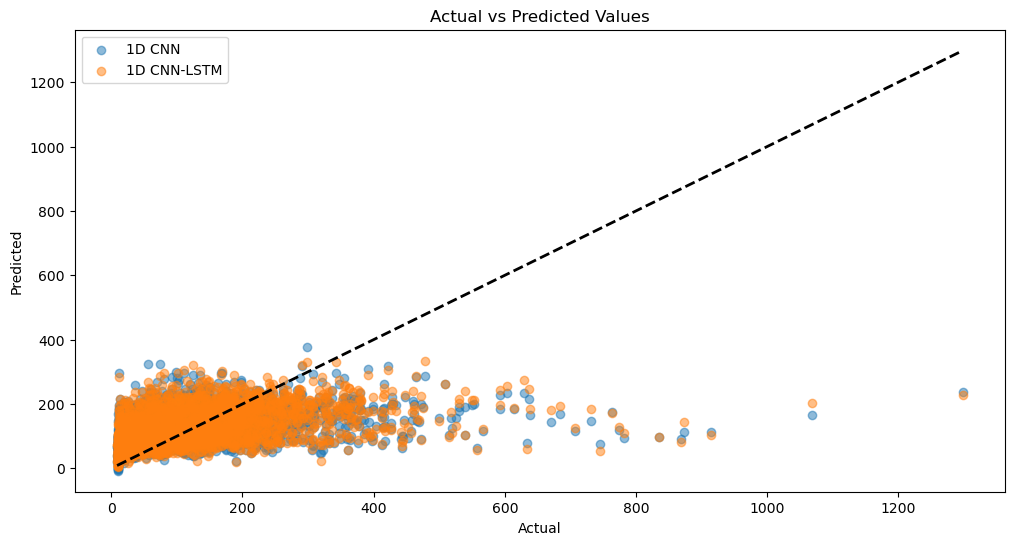

In [21]:
# Plot predictions vs actual for CNN model
plt.figure(figsize=(12, 6))
plt.scatter(y_test.flatten(), y_pred_cnn.flatten(), label='1D CNN', alpha=0.5)
plt.scatter(y_test.flatten(), y_pred_cnn_lstm.flatten(), label='1D CNN-LSTM', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()